In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gzip

# Analyze the results from the error sampling experiment

## Load the data from the one sampled point experiment and the error sampling experiments

In [2]:
df_1_point = pd.read_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/pos_0100.csv"
)
df_1_point.head()

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,1,1,1,0,0,0,0.064,0.267,0.329,0.033,0.154,0.197,0.958,0.942,0.979
1,0,1,1,1,0,0,0,0.859,0.444,0.000,0.753,0.285,0.000,0.991,0.966,0.973
2,0,1,1,1,0,0,0,0.813,0.459,0.000,0.685,0.298,0.000,0.987,0.969,0.973
3,0,1,1,1,0,0,0,0.815,0.473,0.000,0.688,0.310,0.000,0.987,0.970,0.973
4,0,1,1,1,0,0,0,0.783,0.429,0.000,0.644,0.273,0.000,0.984,0.968,0.973


In [3]:
len(df_1_point)

142100

In [4]:
df_error_sampling = pd.read_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/error_sampling_0.csv"
)
df_error_sampling.head()

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,2,2,2,0,0,0,0.585,0.038,0.008,0.413,0.019,0.004,0.960,0.731,0.973
1,0,2,2,2,0,0,0,0.016,0.262,0.000,0.008,0.151,0.000,0.503,0.943,0.973
2,0,2,2,2,0,0,0,0.129,0.150,0.969,0.069,0.081,0.940,0.632,0.878,0.998
3,0,2,2,2,0,0,0,0.102,0.001,0.906,0.054,0.000,0.827,0.498,0.948,0.995
4,0,2,2,2,0,0,0,0.818,0.278,0.008,0.692,0.161,0.004,0.987,0.965,0.958


In [5]:
len(df_error_sampling)

1989400

## Combine both dataframes by inserting the rows from the one point sampling into the error sampling dataframe

In [6]:
n_images = max(df_1_point["image_id"])
batch_size = 50
max_n_points_per_class = 15
df = df_error_sampling.copy()  # create copy to make a new combined dataframe
for image_id in tqdm(range(n_images)):
    index_insert = (
        image_id * batch_size * max_n_points_per_class
    )  # index of start of results for one image
    rows_to_insert = df_1_point[50 * image_id : 50 * image_id + 50]
    df = pd.concat(
        [df.iloc[:index_insert], rows_to_insert, df.iloc[index_insert:]]
    ).reset_index(drop=True)

100%|██████████| 2841/2841 [03:17<00:00, 14.39it/s]


The labeling of points is not correct in the 1-point dataframe, because it was not implemented when doing the experiment to assert the nature of the label. All points are counted as foreground.

To make the count of points correct, I change the label to background, if after sampling from the error map, both points of a class are labeled background. This tells me, that the first point also has to be background.

In [7]:
df.iloc[8 * 50 * 15 + 0]

image_id            8.000
f_points_class_1    1.000
f_points_class_2    1.000
f_points_class_3    1.000
b_points_class_1    0.000
b_points_class_2    0.000
b_points_class_3    0.000
dice_class_1        0.000
dice_class_2        0.706
dice_class_3        0.783
IOU_class_1         0.000
IOU_class_2         0.545
IOU_class_3         0.644
accuracy_class_1    0.966
accuracy_class_2    0.998
accuracy_class_3    0.999
Name: 6000, dtype: float64

In [8]:
for image_id in tqdm(range(n_images)):
    for batch_entry in range(batch_size):
        # check all 3 classes
        for label in [1, 2, 3]:
            if (
                df.iloc[image_id * 50 * 15 + batch_entry + 50][
                    f"b_points_class_{label}"
                ]
                == 2
            ):  # check if both points are background
                df.loc[image_id * 50 * 15 + batch_entry, f"b_points_class_{label}"] = (
                    1  # change label of the single point
                )
                df.loc[image_id * 50 * 15 + batch_entry, f"f_points_class_{label}"] = 0

100%|██████████| 2841/2841 [00:06<00:00, 418.82it/s]


Check if label for class 1 got changed in image where I know there is no class 1 segmentation

In [9]:
df.iloc[8 * 50 * 15 + 0]

image_id            8.000
f_points_class_1    0.000
f_points_class_2    1.000
f_points_class_3    1.000
b_points_class_1    1.000
b_points_class_2    0.000
b_points_class_3    0.000
dice_class_1        0.000
dice_class_2        0.706
dice_class_3        0.783
IOU_class_1         0.000
IOU_class_2         0.545
IOU_class_3         0.644
accuracy_class_1    0.966
accuracy_class_2    0.998
accuracy_class_3    0.999
Name: 6000, dtype: float64

### save in a file

In [10]:
df.to_csv(
    "/Users/lisa/Documents/Master/sam-lab/lisa/results/complete_df.csv", index=False
)

## start with analysis

In [11]:
df = pd.read_csv("/Users/lisa/Documents/Master/sam-lab/lisa/results/complete_df.csv")
df.head(10)

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,0,1,1,1,0,0,0,0.064,0.267,0.329,0.033,0.154,0.197,0.958,0.942,0.979
1,0,1,1,1,0,0,0,0.859,0.444,0.000,0.753,0.285,0.000,0.991,0.966,0.973
2,0,1,1,1,0,0,0,0.813,0.459,0.000,0.685,0.298,0.000,0.987,0.969,0.973
3,0,1,1,1,0,0,0,0.815,0.473,0.000,0.688,0.310,0.000,0.987,0.970,0.973
4,0,1,1,1,0,0,0,0.783,0.429,0.000,0.644,0.273,0.000,0.984,0.968,0.973
5,0,1,1,1,0,0,0,0.772,0.425,0.000,0.629,0.270,0.000,0.983,0.969,0.973
6,0,1,1,1,0,0,0,0.804,0.398,0.000,0.672,0.249,0.000,0.986,0.966,0.973
7,0,1,1,1,0,0,0,0.834,0.473,0.000,0.715,0.309,0.000,0.989,0.969,0.973
8,0,1,1,1,0,0,0,0.778,0.403,0.000,0.637,0.252,0.000,0.984,0.966,0.973
9,0,1,1,1,0,0,0,0.838,0.467,0.000,0.722,0.304,0.000,0.989,0.968,0.973


## Plot 1: Prompt development for exemplary images

In [137]:
n_points = list(range(1, 16))
image_id = 3
image_df = df[df["image_id"] == image_id]
image_df = image_df.reset_index(drop=True)
image_df

,image_id,f_points_class_1,f_points_class_2,f_points_class_3,b_points_class_1,b_points_class_2,b_points_class_3,dice_class_1,dice_class_2,dice_class_3,IOU_class_1,IOU_class_2,IOU_class_3,accuracy_class_1,accuracy_class_2,accuracy_class_3
0,3,1,1,1,0,0,0,0.000,0.044,0.000,0.000,0.023,0.000,0.972,0.363,0.970
1,3,1,1,1,0,0,0,0.257,0.023,0.740,0.147,0.012,0.587,0.922,0.407,0.988
2,3,1,1,1,0,0,0,0.000,0.045,0.000,0.000,0.023,0.000,0.934,0.373,0.970
3,3,1,1,1,0,0,0,0.119,0.004,0.820,0.063,0.002,0.695,0.801,0.540,0.991
4,3,1,1,1,0,0,0,0.045,0.045,0.006,0.023,0.023,0.003,0.957,0.375,0.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,3,10,15,15,5,0,0,0.914,0.767,0.951,0.842,0.622,0.907,0.998,0.992,0.997
746,3,12,14,15,3,1,0,0.866,0.485,0.971,0.764,0.320,0.944,0.996,0.972,0.998
747,3,6,14,15,9,1,0,0.554,0.734,0.965,0.383,0.579,0.933,0.978,0.992,0.998
748,3,13,14,15,2,1,0,0.698,0.578,0.654,0.536,0.406,0.486,0.989,0.979,0.985


Create dictionaries with the scores for 50 runs in 1 image. The resukts are stored in a list of lists for each label in the dictionary.
The entries in the outer list are the different runs and one entry in the inner lists is the result value for a specific number of points in the prompt per label (1-15).

In [138]:
dice_scores = {1: [], 2: [], 3: []}
IOU_scores = {1: [], 2: [], 3: []}
for batch_entry in range(batch_size):
    for label in [1, 2, 3]:
        label_scores_dice = []
        label_scores_IOU = []
        for n in n_points:
            index = (n - 1) * batch_size + batch_entry

            label_scores_dice.append(image_df.loc[index, f"dice_class_{label}"])
            label_scores_IOU.append(image_df.loc[index, f"IOU_class_{label}"])
        dice_scores[label].append(label_scores_dice)
        IOU_scores[label].append(label_scores_IOU)

### Dice Score

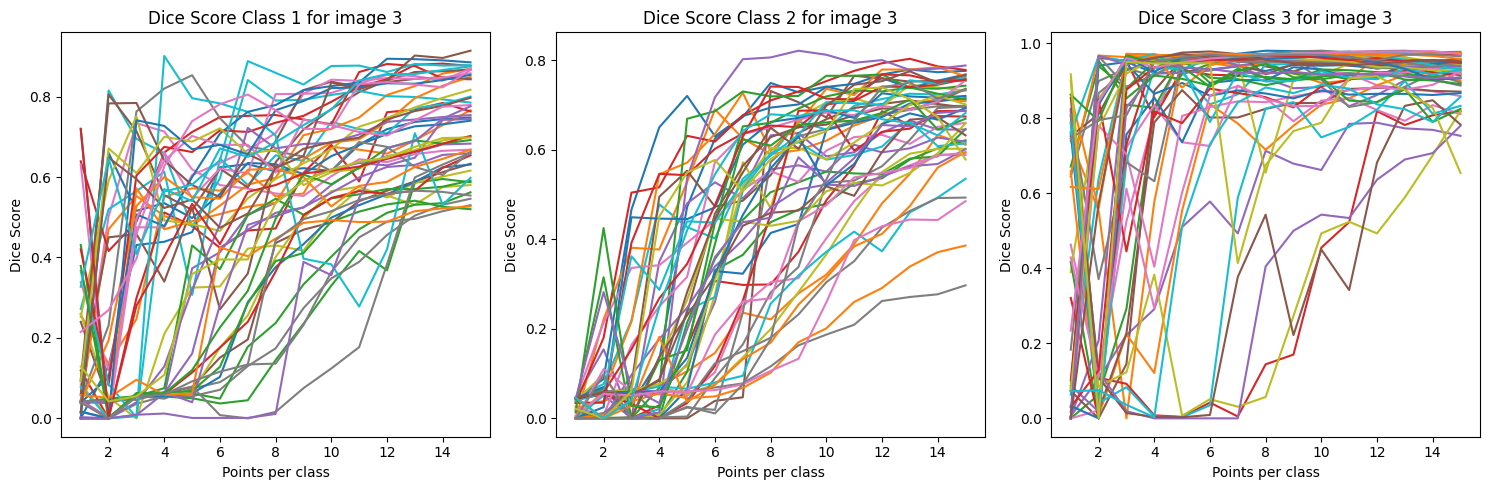

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    for j, line in enumerate(dice_scores[label]):
        ax.plot(range(1, 16), line, label=f"Line {j+1}")

    ax.set_xlabel("Points per class")
    ax.set_ylabel("Dice Score")
    ax.set_title(f"Dice Score Class {label} for image {image_id}")


plt.tight_layout()
plt.show()

Calculate mean scores between the classes

In [140]:
dice_means = []
for run in range(batch_size):
    run_means = []
    for n in range(15):
        result = 0
        for label in [1, 2, 3]:
            result += dice_scores[label][run][n]
        run_means.append(result / 3)
    dice_means.append(run_means)

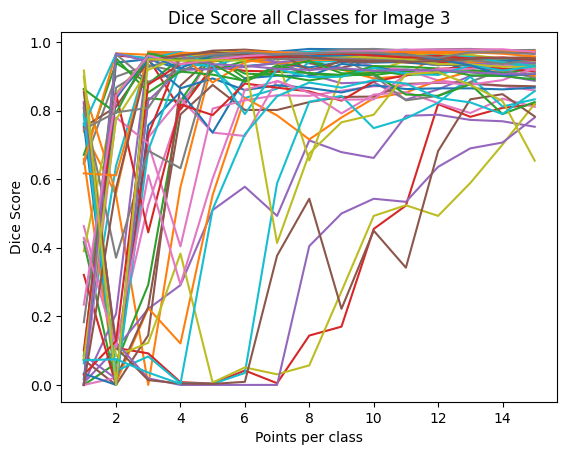

In [141]:
for j, line in enumerate(dice_scores[label]):
    plt.plot(range(1, 16), line, label=f"Line {j+1}")

# Add labels and legend
plt.xlabel("Points per class")
plt.ylabel("Dice Score")
plt.title(f"Dice Score all Classes for Image {image_id}")

# Show the plot
plt.show()

### IOU Score

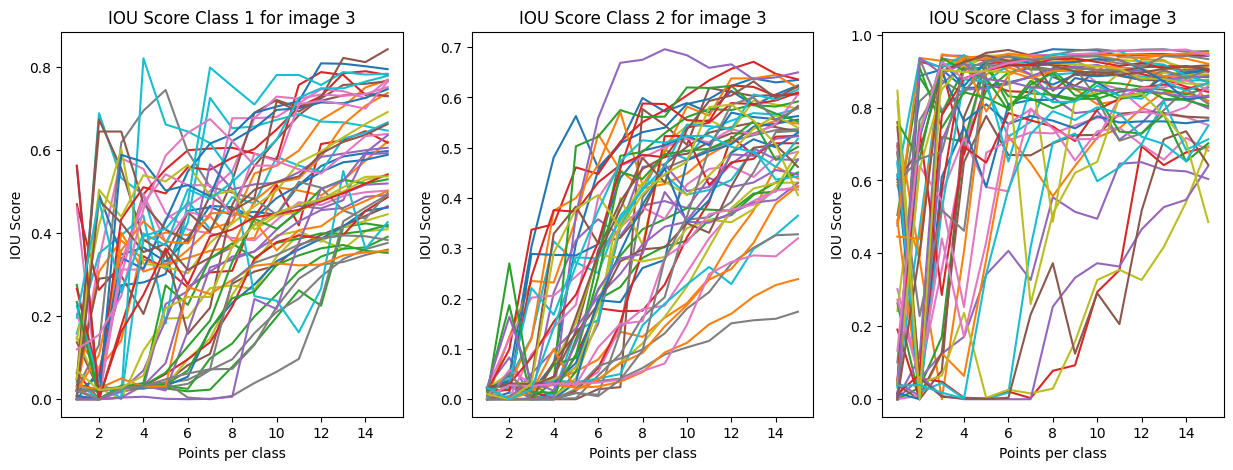

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    for j, line in enumerate(IOU_scores[label]):
        ax.plot(range(1, 16), line, label=f"Line {j+1}")

    ax.set_xlabel("Points per class")
    ax.set_ylabel("IOU Score")
    ax.set_title(f"IOU Score Class {label} for image {image_id}")

In [143]:
IOU_means = []
for run in range(batch_size):
    run_means = []
    for n in range(15):
        result = 0
        for label in [1, 2, 3]:
            result += IOU_scores[label][run][n]
        run_means.append(result / 3)
    IOU_means.append(run_means)

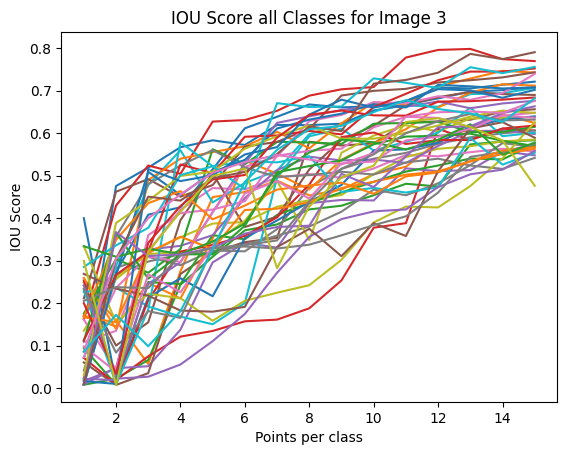

In [144]:
for j, line in enumerate(IOU_means):
    plt.plot(range(1, 16), line, label=f"Line {j+1}")

# Add labels and legend
plt.xlabel("Points per class")
plt.ylabel("IOU Score")
plt.title(f"IOU Score all Classes for Image {image_id}")

# Show the plot
plt.show()

# Plot 2 - statistics on the results for the complete dataset

For a class only include results from images that really contain this class

In [94]:
with gzip.open(
    "/Users/lisa/Documents/Master/sam-lab/ACDC/ground_truth.npy.gz", "rb"
) as f:
    # Load the NumPy array from the file
    ground_truth = np.load(f)

In [95]:
def get_class_list(class_num, ground_truth):
    array1 = np.any(ground_truth == class_num, axis=1)
    array2 = np.any(array1 == True, axis=1)
    class_indices = np.where(array2 == True)
    indices = list(class_indices[0])
    return indices

In [96]:
class_indices = {}
for c in [1, 2, 3]:
    class_indices[c] = get_class_list(c, ground_truth)

In [109]:
dice = {"mean": {1: [], 2: [], 3: []}, "std": {1: [], 2: [], 3: []}}
IOU = {"mean": {1: [], 2: [], 3: []}, "std": {1: [], 2: [], 3: []}}

# for every number of points load the results for the complete dataset
for n in range(1, 16):
    for label in [1, 2, 3]:
        df_n_points = df[
            (df["f_points_class_1"] + df["b_points_class_1"] == n)
            & df["image_id"].isin(class_indices[label])
        ]
        dice["mean"][label].append(df_n_points[f"dice_class_{label}"].mean())
        dice["std"][label].append(df_n_points[f"dice_class_{label}"].std())

        IOU["mean"][label].append(df_n_points[f"IOU_class_{label}"].mean())
        IOU["std"][label].append(df_n_points[f"IOU_class_{label}"].std())

### Dice

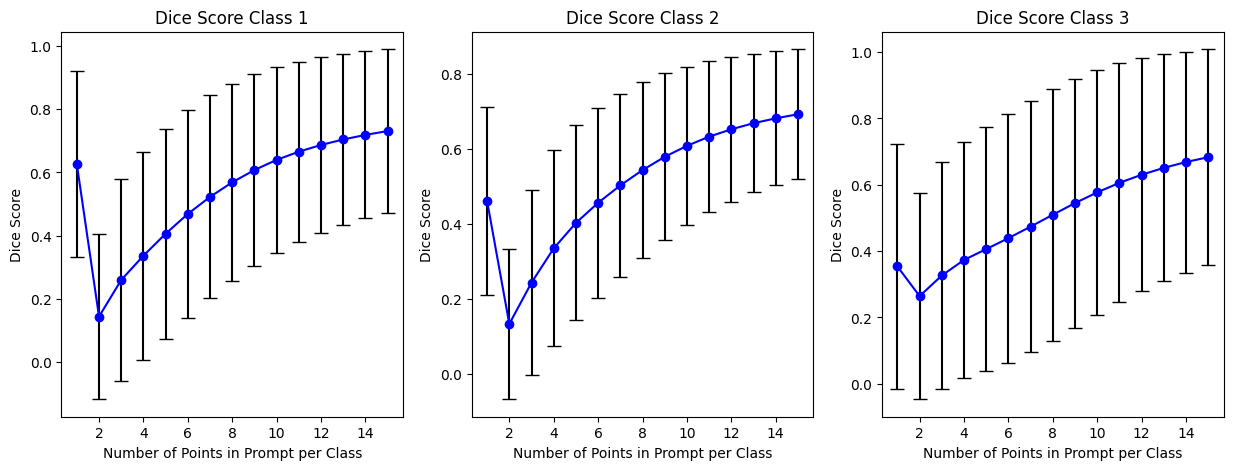

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    ax.errorbar(
        range(1, 16),
        dice["mean"][label],
        yerr=dice["std"][label],
        capsize=5,
        fmt="-o",
        color="blue",
        ecolor="black",
    )

    ax.set_xlabel("Number of Points in Prompt per Class")
    ax.set_ylabel("Dice Score")
    ax.set_title(f"Dice Score Class {label}")


plt.show()

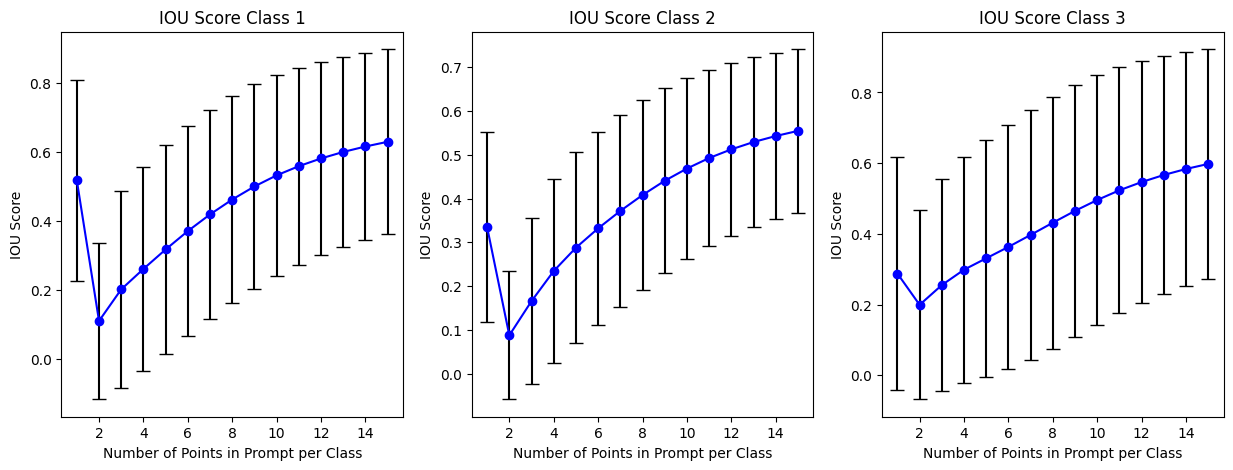

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate([1, 2, 3]):
    ax = axes[i]
    ax.errorbar(
        range(1, 16),
        IOU["mean"][label],
        yerr=IOU["std"][label],
        capsize=5,
        fmt="-o",
        color="blue",
        ecolor="black",
    )

    ax.set_xlabel("Number of Points in Prompt per Class")
    ax.set_ylabel("IOU Score")
    ax.set_title(f"IOU Score Class {label}")

plt.show()